In this file, I only focus on predicting a time-series by using `ARIMA` and `SARIMA` model

## 0. Import libraries & viewing data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

df = pd.read_csv(r"D:\Nhan\Data\AirPassengers.csv")
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


## 1. Using `ARIMA`

A popular and widely used statistical method for time series forecasting is the **`ARIMA model`**. It explicitly caters to a suite of standard structures in time series data, and as such provides a simple yet powerful method for making skillful time series forecasts.

**`ARIMA`** is an `acronym` that stands for **`AutoRegressive Integrated Moving Average`**. It is a class of model that captures a suite of different standard temporal structures in time series data.

This `acronym` is descriptive, capturing the key aspects of the model itself. Briefly, they are:

> `AR: Autoregression`. A model that uses the `dependent relationship` between an observation and some number of lagged observations.
>
> `I: Integrated`. The use of `differencing of raw observations` (e.g. `subtracting an observation from an observation at the previous time step`, that is $\Delta_t = x_t - x_{t-1}$ ) in order to make the `time series stationary`, Reminder. 
>
>> A time-series $(X_t)_{t \geq 0}$ is said to be `stationary` if for all $t, s, h$ then

$$ \mathbb{E}X_t = \mu , \quad \mathbb{E}X^2_t < \infty \text{ and } \text{Cov}\left( X_t, X_s \right) = \text{Cov}\left( X_{t+h}, X_{s+h} \right)  $$
>
>> In intuition (by graph / plot), in a **`stationary time series`**; data does not have any upward or downward trend or seasonal effects; this meant `Mean or variance` are `consistent over time`. 
>
>> In **`non-stationary time series`**: data show `trends`, `seasonal` effects, and `other structures depend on time`. Forecasting performance is dependent on the time of observation. `Mean and variance change over time and a drift in the model is captured`.
>
>> See the illustration bellow! The *`left panel`* is the plot of `white-noise` $x_t \sim \mathcal{N}(0, 1)$ which be `stationary time-series` while the *`right-panel`* is the plot of the number of passengers in the dataset `AirPassengers.csv` which increase over time.

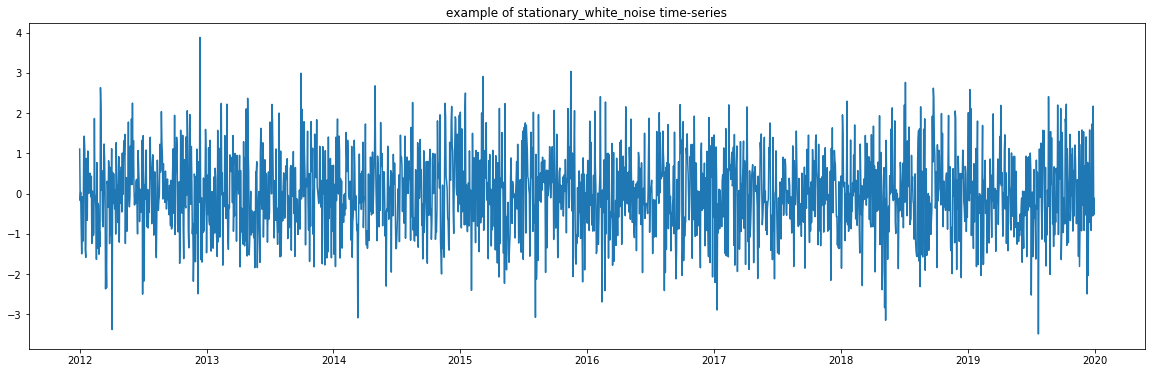

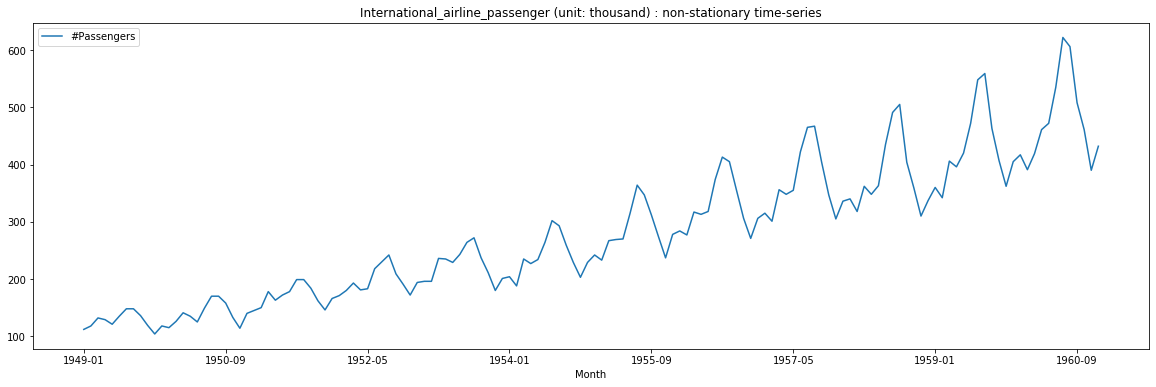

In [3]:
white_noise = np.random.normal(0, 1, size = 2000)
series = df.set_index('Month')
plt.figure(figsize = (20, 6))
plt.plot(white_noise)
plt.xticks(range(0, 2001, 250), 
           ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'])
plt.title('example of stationary_white_noise time-series')
series.plot(title = 'International_airline_passenger (unit: thousand) : non-stationary time-series' , figsize = (20, 6))

> `MA: Moving Average.` A model that `uses the dependency between an observation` and a `residual error` from a `moving average` model applied to `lagged observations`.

### What does the `p`, `d` and `q` in ARIMA(p, d, q) model mean?

**The first step to build an ARIMA model is to make the time series stationary.**

A `linear regression model` is constructed including the specified number and type of terms, and the data is prepared by a `degree of differencing` in order to `make it stationary`, i.e. to `remove trend` and `seasonal structures` that negatively affect the `regression model`.

**So how to make a series stationary?**

The most common approach is to difference it. That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.

Each of these components are explicitly specified in the model as a parameter. 

A `standard notation` is used of `ARIMA(p,d,q)` where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used. The `parameters` of the `ARIMA model` are defined as follows:

> `d:` The `number of times that the raw observations are differenced`, also called the degree of differencing.
>> The value of `d`, therefore, is the `minimum number of differencing` needed to `make the series stationary`. And if the time series is `already stationary, then d = 0`. 
>
>> A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the `ARIMA model` can be configured to perform the `function of an ARMA model`, and even a simple `AR`, `I`, or `MA model`.
>
> `p:` The `number of lag observations` included in the model, also called the `lag order` of `‘Auto Regressive’ (AR) term`.. It refers to the number of lags of Y to be used as `predictors`.
>
>> A `pure Auto Regressive (AR only)` model is one where $Y_t$ `depends only on its own lags`. That is, $Y_t$ is a `function` of the `‘lags of` $Y_t$ `’`.
$$ Y_t = \beta_0 + \beta_1 Y_{t-1} + \ldots + \beta_p Y_{t -p} + \varepsilon_t $$
> where, $Y_{t-1}$ is the `lag_1` of the series, $\beta_k, k = 1,\ldots, p$ is the coefficient of `lag_k` that the model estimates and $\beta_0$ is the intercept term, also estimated by the model.
>
> `q:` The `size of the moving average window`, also called the `order of moving average (MA) term`. It refers to the `number of lagged forecast errors` that should go into the ARIMA Model.
>> Likewise, a `pure Moving Average (MA only)` model is one where $Y_t$ depends only on the lagged forecast errors.
$$ Y_t = \beta_0 + \varepsilon_t $$

Adopting an `ARIMA` model for a time series assumes that the underlying process that generated the observations is an `ARIMA` process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.


### 1.1. Reminder: Checking for Stationarity 

- using `plots` from `histogram` or `line-plot`

- using `Summary Statistics`

**A. Using `plots`**

For the `line-plot` (look back the `Line [2]`), sequence plot (at the `bottom (Air_passengers)`) obviously shows an `upward trend` as time goes by. We can also observe `seasonal trends` from similar shape in each year so this is `non-stationary` while the `top` is consistent at mean and variance!

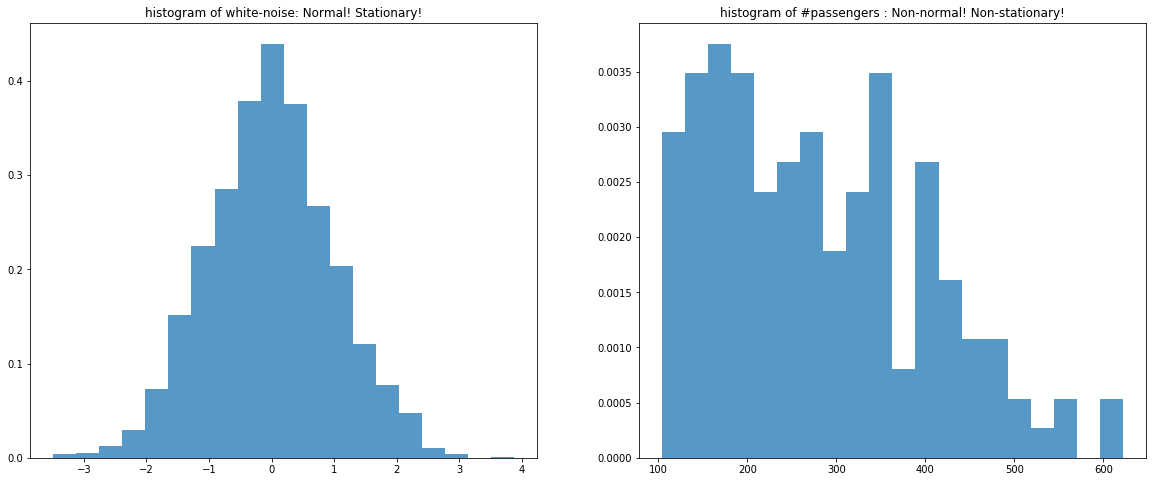

In [4]:
plt.figure(figsize = (20, 8))

plt.subplot(121), plt.hist(x = white_noise, bins = 20, density = True, alpha=0.75), 
plt.title('histogram of white-noise: Normal! Stationary!')

plt.subplot(122), plt.hist(x = series.values, bins = 20, density = True, alpha=0.75),
plt.title('histogram of #passengers : Non-normal! Non-stationary!')
plt.show()

In these histogram, if the data is `stationary (left panel)` the summary statistics should be consistent over time. The mean should be consistent with a consistent variance indicating a Gaussian distribution. In the `right panel`, the histogram does not show Gaussian distribution and another indication of non-stationary time series data.

#### B. Using `Summary Statistics`

In [5]:
time_series = [white_noise, series.values]
titles = ['Stationary ts', 'Non-stationary ts']
for k in range(2):
    print(titles[k], ':')
    X = time_series[k]
    split = len(X) // 3
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('\tmean1 = %.3f, mean2 = %.3f' % (mean1, mean2))
    print('\tvariance1 = %.3f, variance2 = %.3f' % (var1, var2))

Stationary ts :
	mean1 = 0.001, mean2 = -0.012
	variance1 = 0.954, variance2 = 1.009
Non-stationary ts :
	mean1 = 158.375, mean2 = 341.260
	variance1 = 1071.859, variance2 = 9753.005


**`Summary Statistics`**, the mean and variance are very different from the first and second half of the data. Another indication of non-stationary data.

#### C. `Augmented Dickey-Fuller test (ADF)`

`ADF` tests the null hypothesis that a unit root is present in time series sample. `ADF` statistic is a negative number and more negative it is the stronger the rejection of the hypothesis that there is a unit root.
> `Null Hypotehsis (H0)`: If accepted, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
>
> `Alternate Hypothesis (H1)`: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary.
>
> `p-value > 0.05`: `Accept H0`, the data `has a unit root` and is `non-stationary`
>
> `p-value ≤ 0.05`: `Reject H0`. the data `does not have a unit root` and is `stationary`

In [6]:
from statsmodels.tsa.stattools import adfuller

X = series.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


`ADF Stat` has a `p-value` is also `above 0.05`. The data is closer to being stationary, but still has a `unit root` and is `non-stationary`. 

Obviously, for `X = white_noise` then the `ADF Stat` will return `stationary`, see bellow!

In [7]:
X = white_noise
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -29.703549
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


### 1.2. `Auto-correlation` function & plot

The **`autocovariance function`** at lag **k**

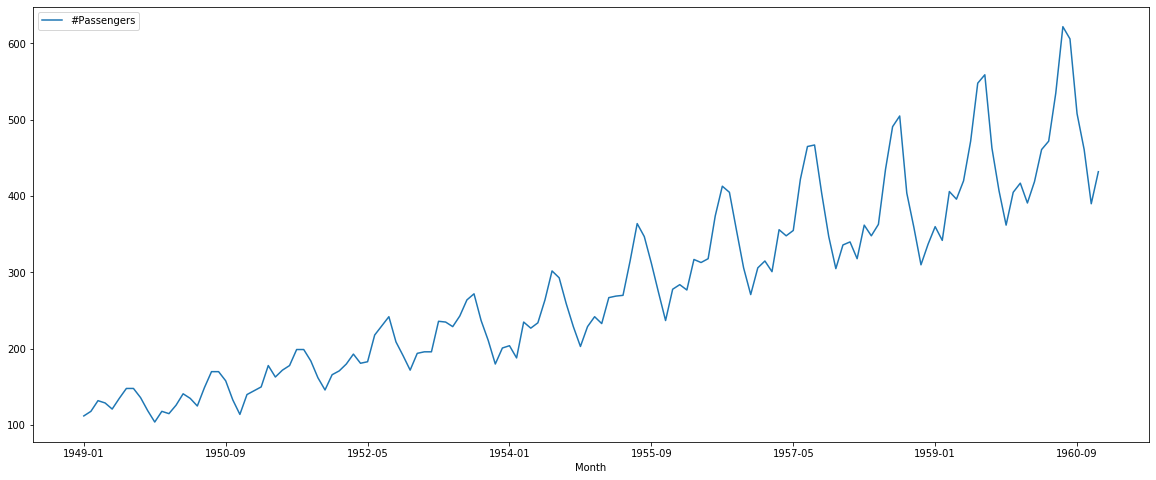

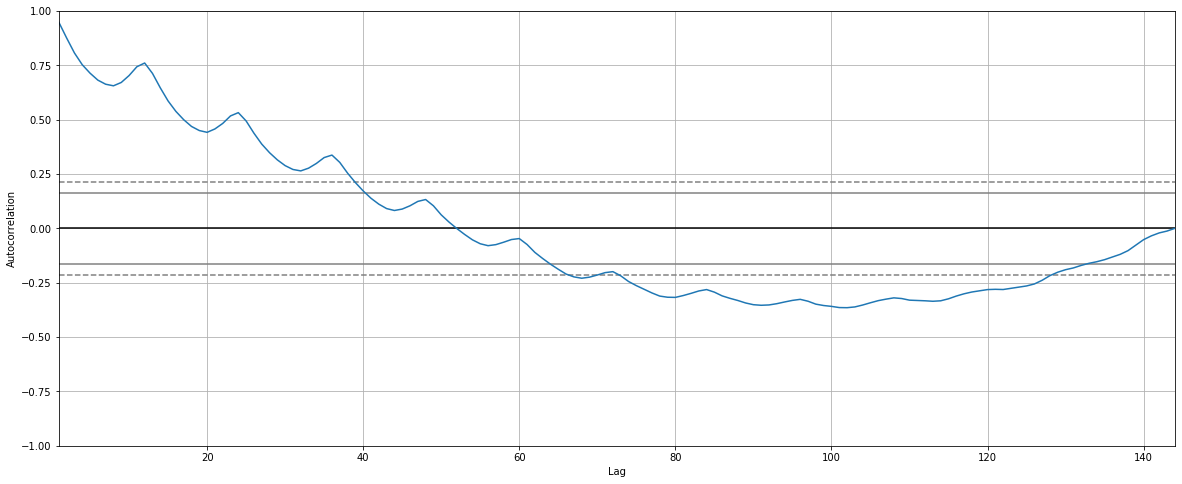

In [8]:
from pandas.plotting import autocorrelation_plot

df.plot(x = 'Month', y = '#Passengers', figsize = (20, 8))

plt.figure(figsize = (20, 8))
autocorrelation_plot(df['#Passengers'])

In [12]:
model = ARIMA(df['#Passengers'], order=(9,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(9, 1, 0)   Log Likelihood                -658.251
Method:                       css-mle   S.D. of innovations             23.786
Date:                Thu, 30 Jul 2020   AIC                           1338.501
Time:                        20:18:59   BIC                           1371.092
Sample:                             1   HQIC                          1351.745
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.6801      0.637      4.210      0.000       1.432       3.928
ar.L1.D.#Passengers     0.0660      0.083      0.797      0.426      -0.096       0.228
ar.L2.D.#Passeng

There are 144 observations in this dataset!


### Now, using `train_test_split_Time-series` to evaluate the problems

In [18]:
from sklearn.metrics import mean_squared_error, r2_score

ts = series.values.reshape(-1)
size = int(len(ts) * 0.7)
ts_train, ts_test = ts[0:size], ts[size:]
#history = [x for x in ts_train]
model = ARIMA(ts_train, order=(9,1,0))
model_fit = model.fit(disp=0)
predictions = []
model.predict(ts_test).shape, ts_train.shape, ts_test.shape

((99,), (100,), (44,))

### 2. Using `SARIMA`